Database 4: Data Fitting
========================

In this tutorial, we use the aggregator to load models and data from a `NonLinearSearch` and use them to reperform
fits to the data.

It is here the use of generators is absolutely essential. We are going to manipulating datasets which use a lot of
memory.

In [1]:
%matplotlib inline
from pyprojroot import here
workspace_path = str(here())
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

from os import path
import autofit as af
import autolens as al
import autolens.plot as aplt

/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace
Working Directory has been set to `/mnt/c/Users/Jammy/Code/PyAuto/autolens_workspace`


Below, we set up the aggregator as we did in the previous tutorial.

In [2]:
agg = af.Aggregator(directory=path.join("output", "database"))

Aggregator loading phases... could take some time.

 A total of 3 phases and results were found.


Again, we create a list of the Samples of each phase.

In [3]:
agg_filter = agg.filter(agg.directory.contains("phase_runner"))

Filter found a total of 3 results


We can also use the aggregator to load the dataset of every lens our `Phase` fitted. This generator returns the 
dataset as the `Imaging` objects we passed to the phase when we ran them.

Datasets:



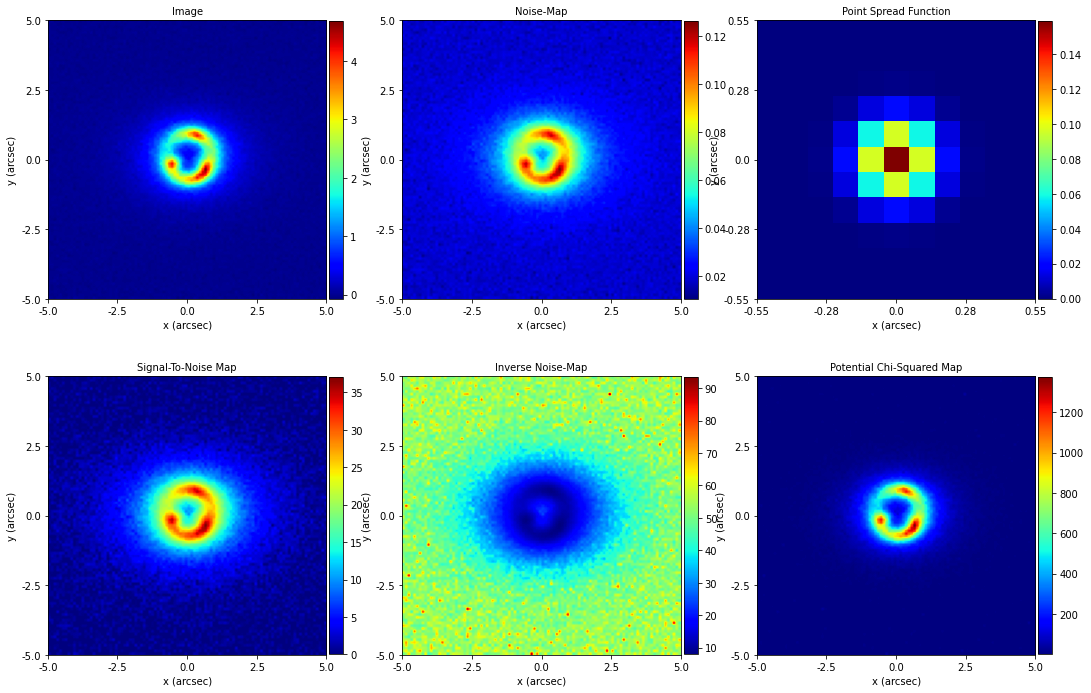

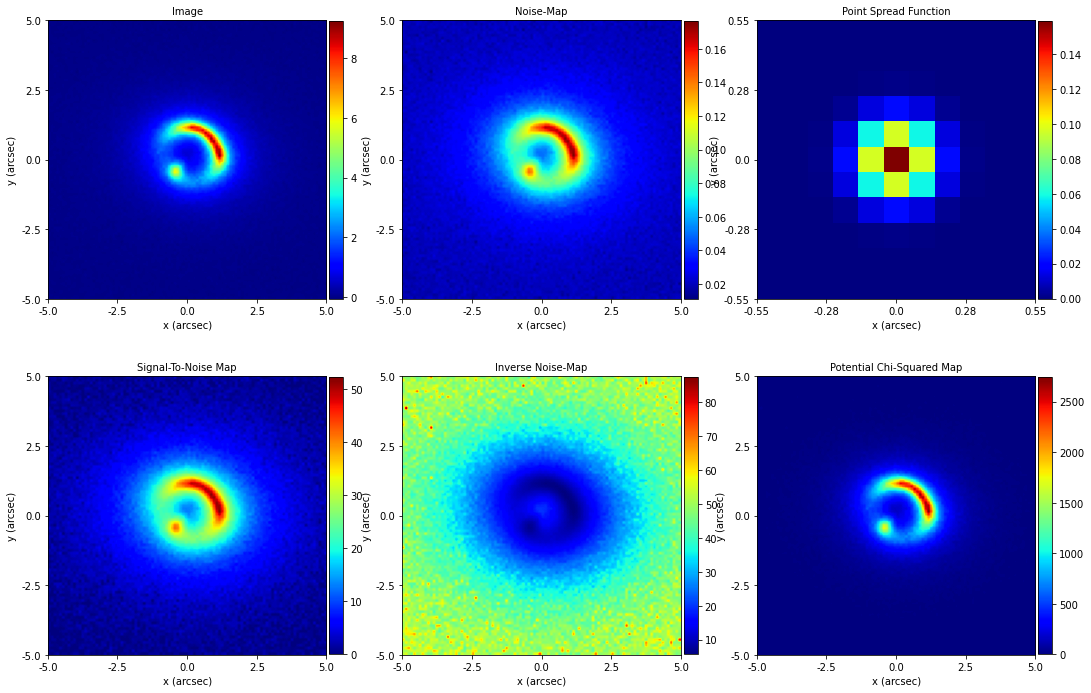

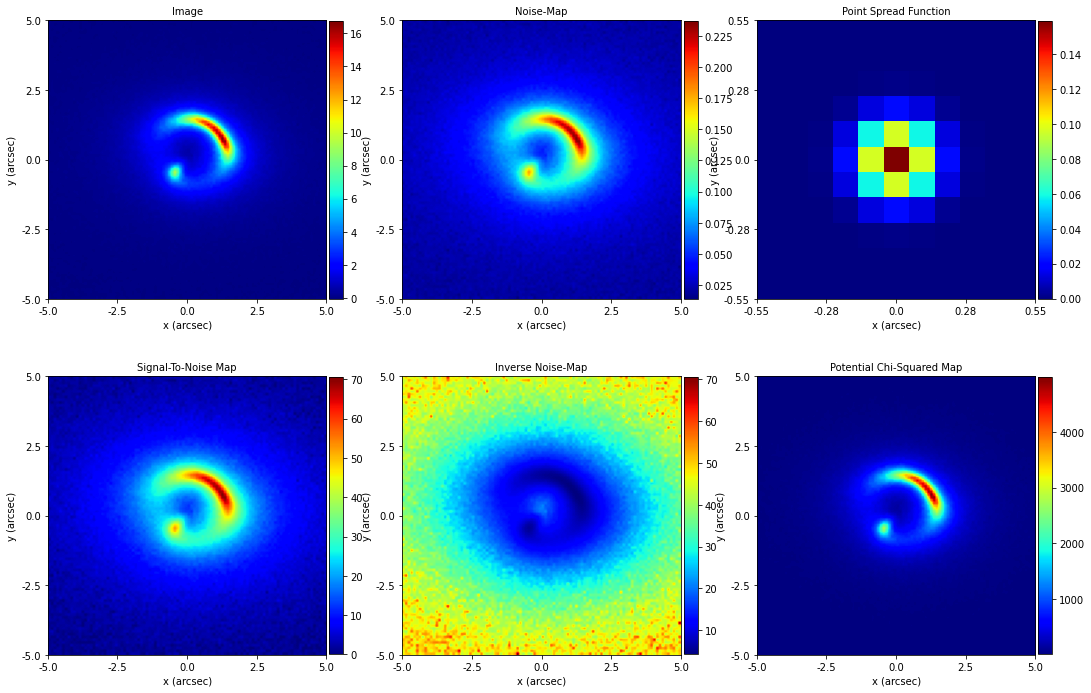

In [4]:
dataset_gen = agg_filter.values("dataset")

print("Datasets:")
print(dataset_gen, "\n")
print(list(dataset_gen)[0])

for dataset in agg_filter.values("dataset"):

    imaging_plotter = aplt.ImagingPlotter(imaging=dataset)
    imaging_plotter.subplot_imaging()

The name of the dataset we assigned when we ran the phase is also available, which helps us to label the lenses 
on plots.

In [5]:
print("Dataset Names:")
dataset_gen = agg_filter.values("dataset")
print([dataset.name for dataset in dataset_gen])

Dataset Names:
['mass_sie__source_sersic__0', 'mass_sie__source_sersic__1', 'mass_sie__source_sersic__2']


The info dictionary we passed is also available.

In [6]:
print("Info:")
info_gen = agg_filter.values("info")
print([info for info in info_gen])

Info:
[{'redshift_lens': 0.5, 'redshift_source': 1.0, 'velocity_dispersion': 250000, 'stellar mass': 100000000000.0}, {'redshift_lens': 0.5, 'redshift_source': 1.0, 'velocity_dispersion': 250000, 'stellar mass': 100000000000.0}, {'redshift_lens': 0.5, 'redshift_source': 1.0, 'velocity_dispersion': 250000, 'stellar mass': 100000000000.0}]


we'll also need the masks we used to fit the lenses, which the aggregator also provides.

In [7]:
mask_gen = agg_filter.values("mask")
print("Masks:")
print(list(mask_gen), "\n")

Masks:
[Mask2D([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]), Mask2D([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True]]), Mask2D([[ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  True,  True,  True],
        ...,
        [ True,  True,  True, ...,  True,  True,  True],
        [ True,  True,  True, ...,  T

Lets plot each dataset again now with its mask, using generators.

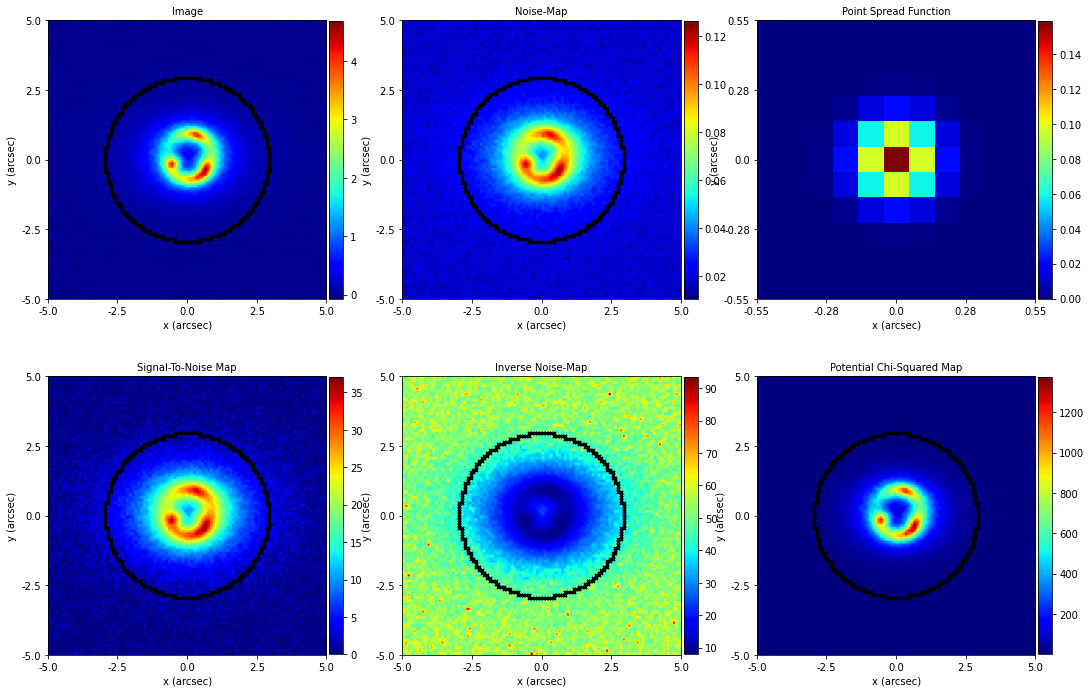

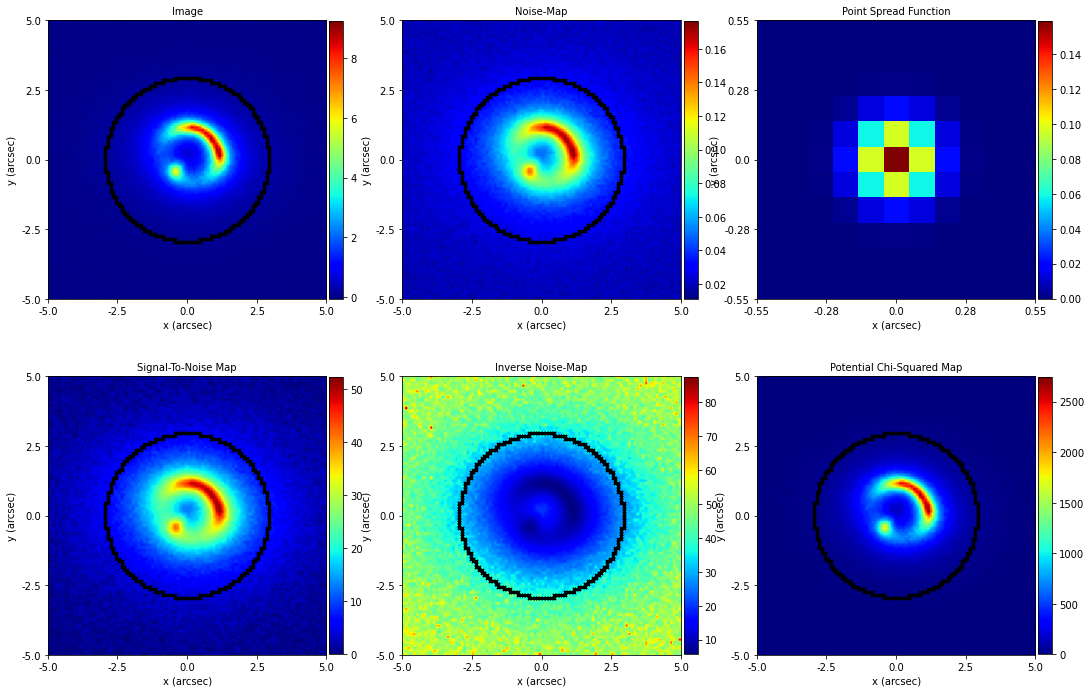

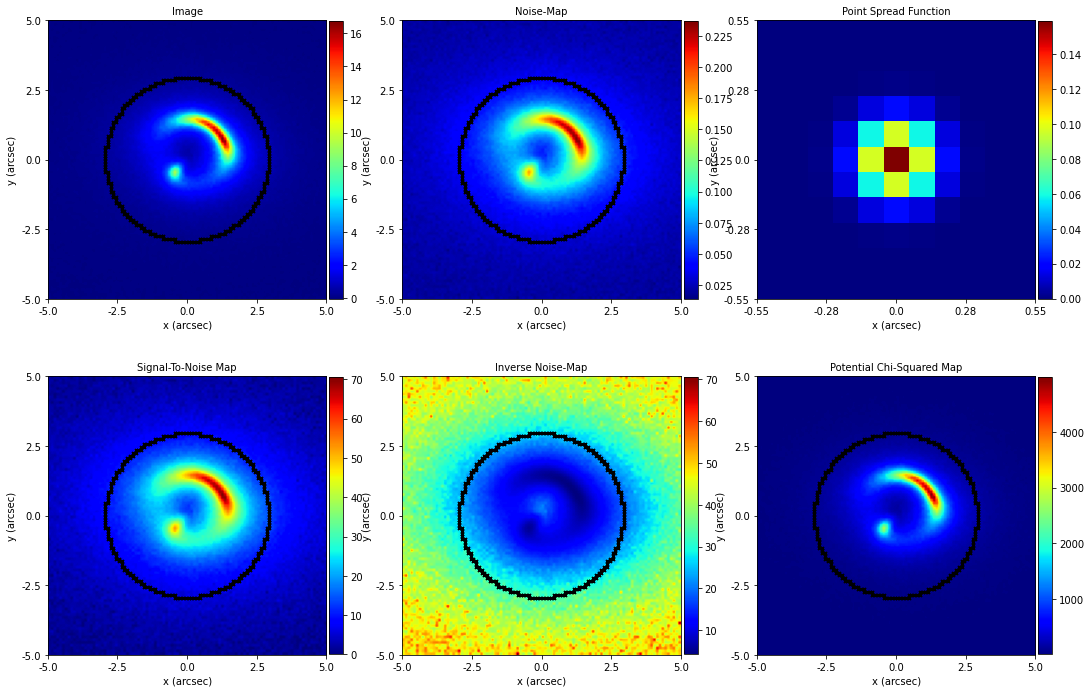

In [8]:
dataset_gen = agg_filter.values("dataset")
mask_gen = agg_filter.values("mask")

for dataset, mask in zip(dataset_gen, mask_gen):

    visuals_2d = aplt.Visuals2D(mask=mask)

    imaging_plotter = aplt.ImagingPlotter(imaging=dataset, visuals_2d=visuals_2d)
    imaging_plotter.subplot_imaging()

To reperform the fit of each maximum log likelihood lens model we can use the following generator.

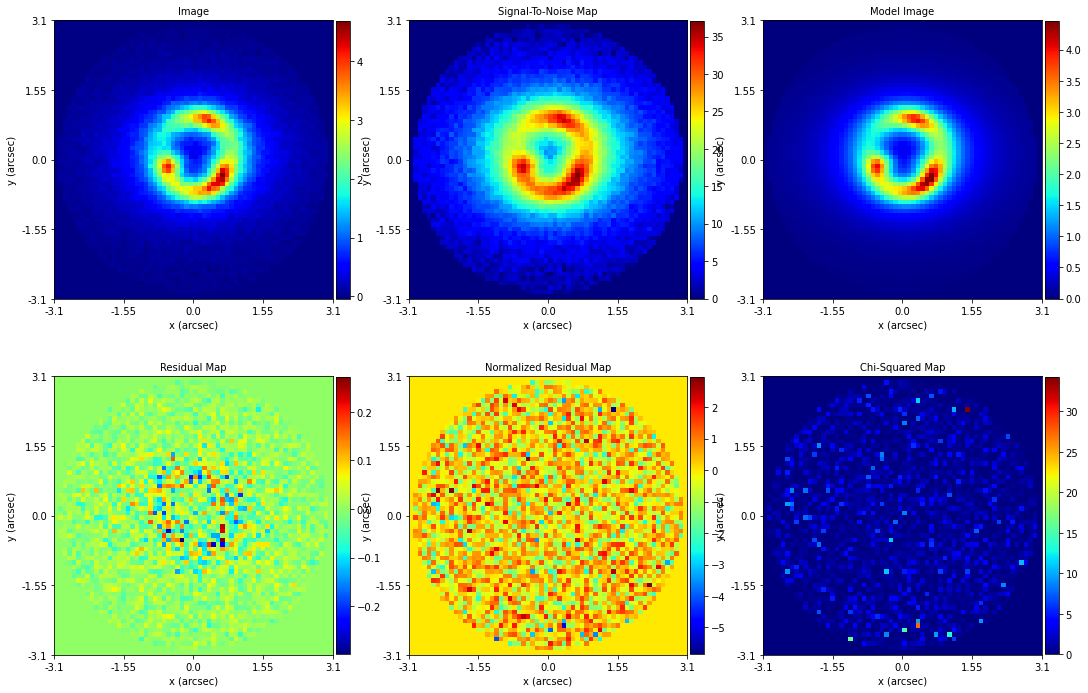

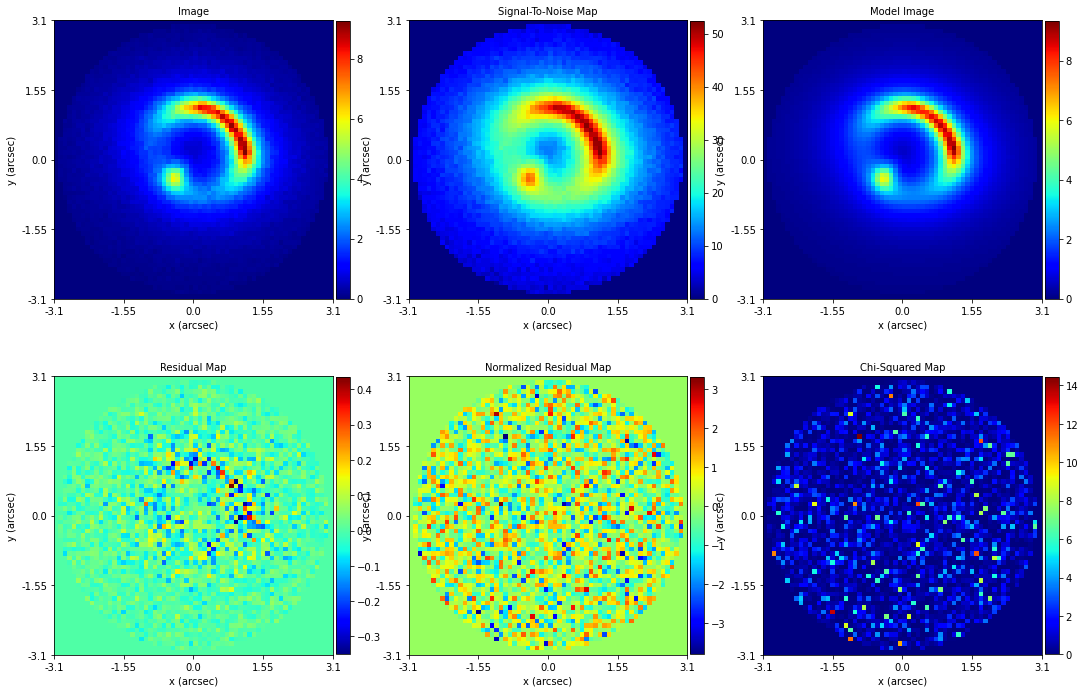

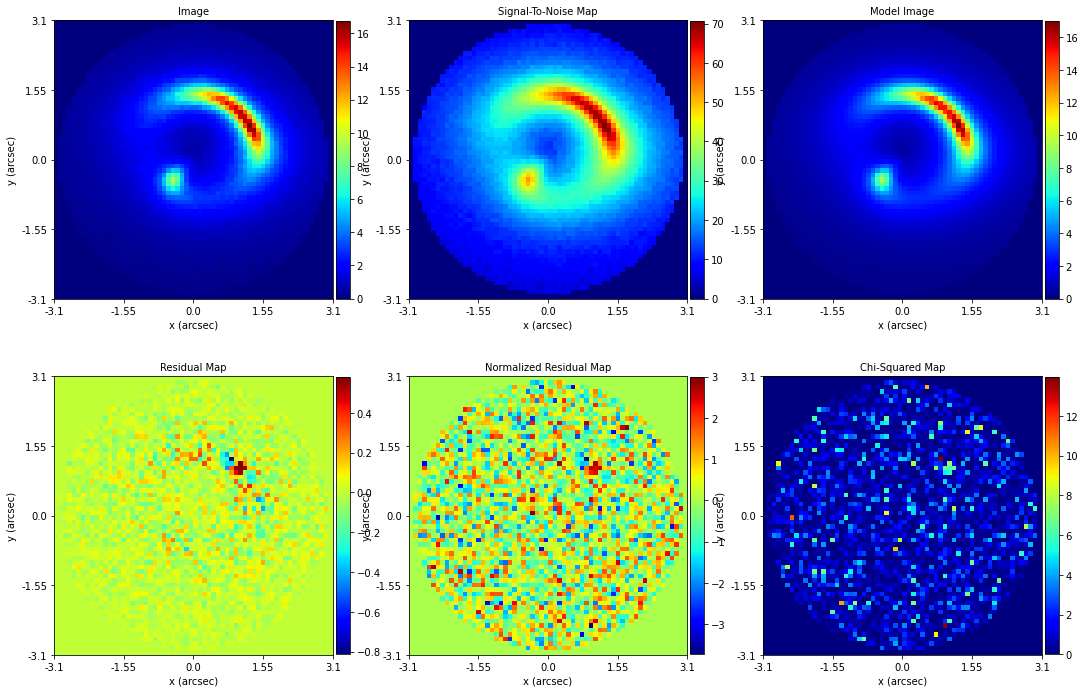

In [9]:


def make_fit_generator(agg_obj):

    output = agg_obj.samples
    dataset = agg_obj.dataset
    mask = agg_obj.mask

    masked_imaging = al.MaskedImaging(imaging=dataset, mask=mask)

    tracer = al.Tracer.from_galaxies(
        galaxies=output.max_log_likelihood_instance.galaxies
    )

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


fit_gen = agg_filter.map(func=make_fit_generator)

for fit in fit_gen:

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

There`s a problem though, the MaskedImaging object is made with a custom phase input. For example, it receive a 
`grid_class` defining which grid it uses to fit the data. This isn't included in the generator above. Thats bad!

The output has a meta_dataset attribute containing all the information on how the MaskedImaging was created for the
actualy phase.

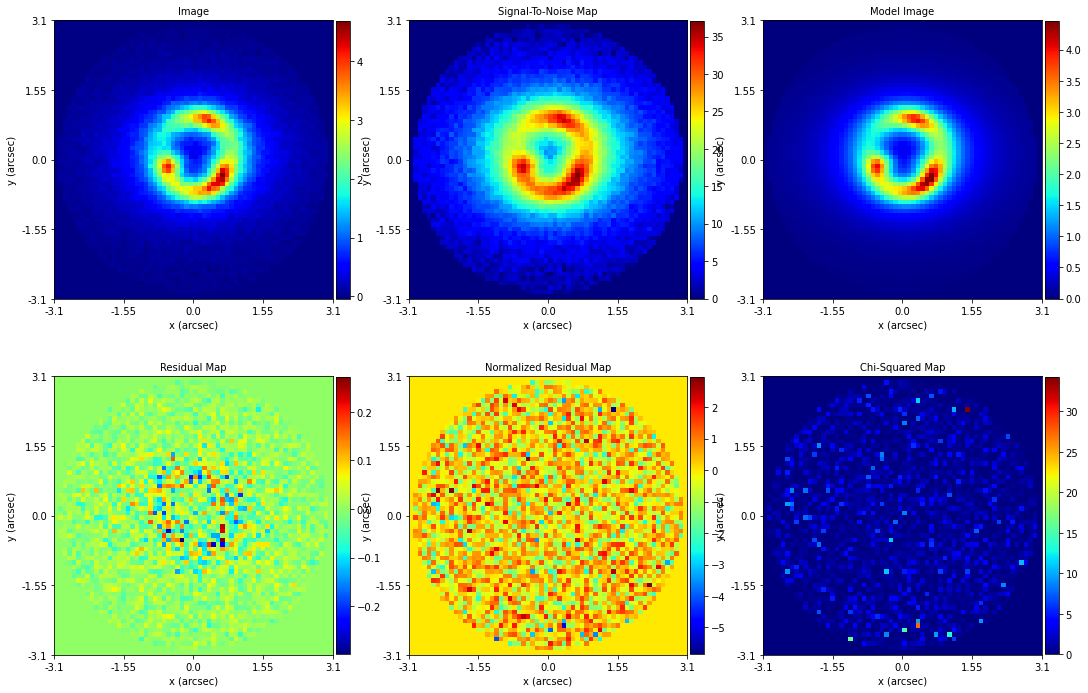

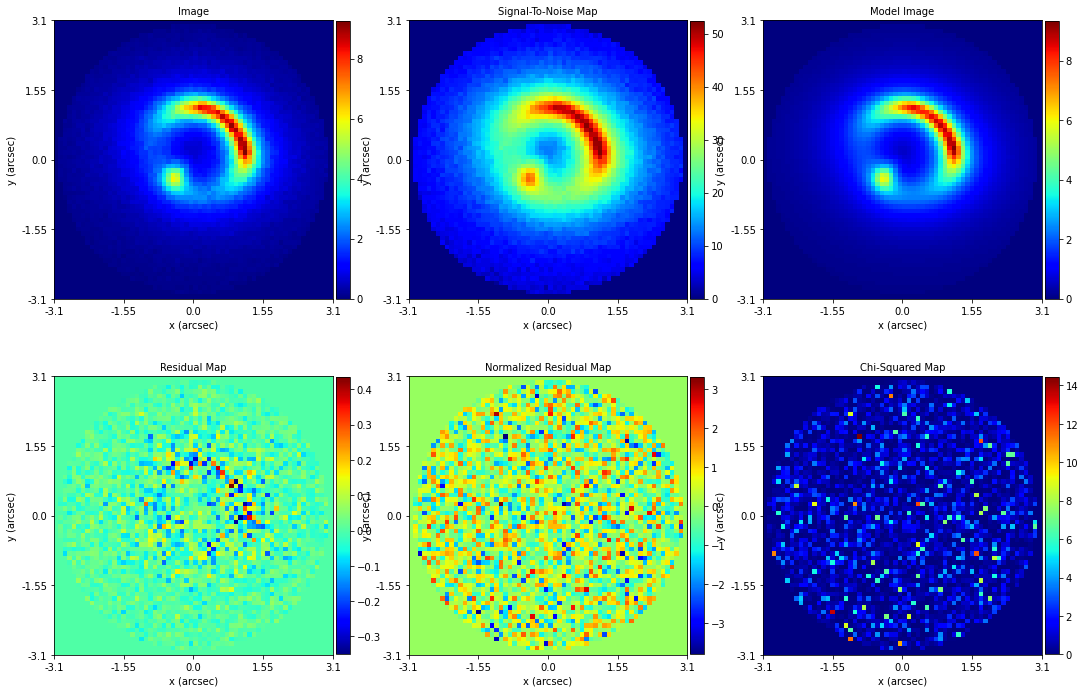

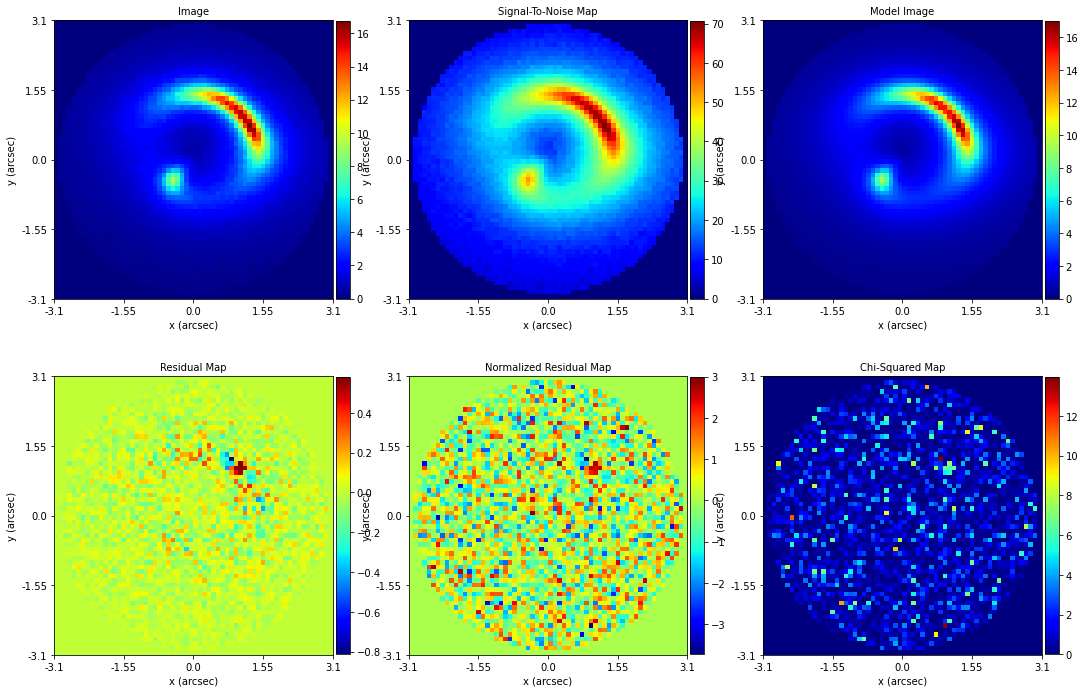

In [10]:


def make_fit_generator(agg_obj):

    output = agg_obj.samples
    dataset = agg_obj.dataset
    mask = agg_obj.mask

    """This corresponds to `SettingsPhaseImaging` used un the runner script."""
    settings = agg_obj.settings

    masked_imaging = al.MaskedImaging(
        imaging=dataset, mask=mask, settings=settings.settings_masked_imaging
    )

    tracer = al.Tracer.from_galaxies(
        galaxies=output.max_log_likelihood_instance.galaxies
    )

    return al.FitImaging(
        masked_imaging=masked_imaging,
        tracer=tracer,
        settings_pixelization=settings.settings_pixelization,
        settings_inversion=settings.settings_inversion,
    )


fit_gen = agg_filter.map(func=make_fit_generator)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

Thats a lot of input parameters! The good news is this means in the aggregator we can customize exactly how the 
MaskedImaging is set up. The bad news is this requires a lot of lines of code, which is prone to typos and errors. 

If you are writing customized generator functions, the PyAutoLens aggregator module also provides convenience methods
for setting up objects *within* a generator. Below, we make the MaskedImaging and Tracer using these methods, which
perform the same functions as the generator above, including the SettingsPhaseImaging.

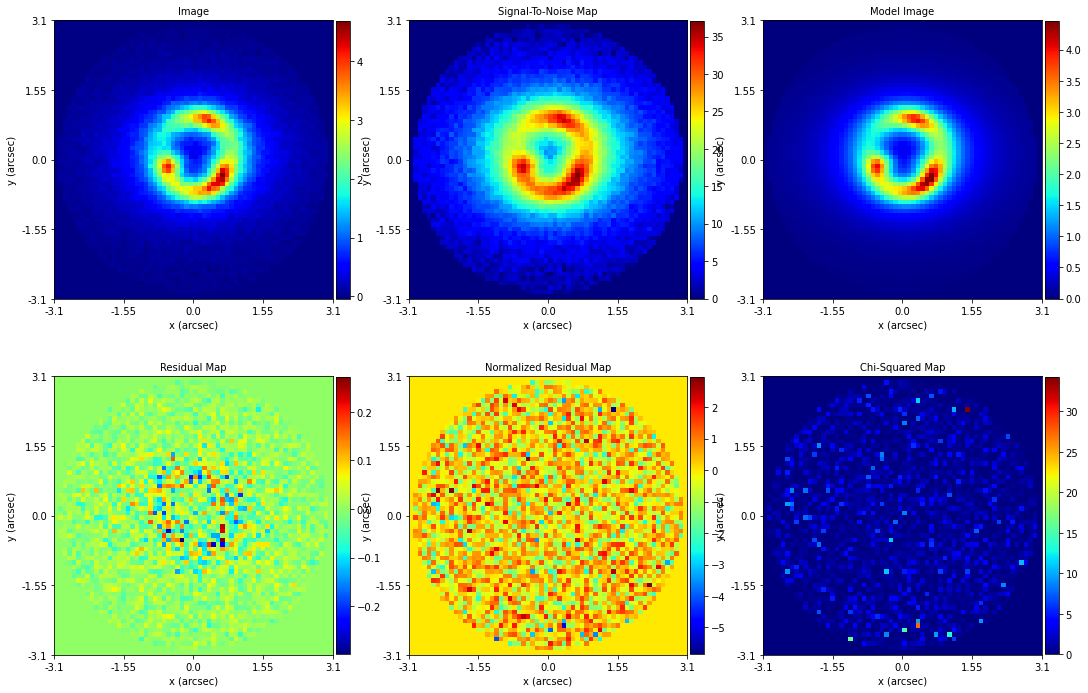

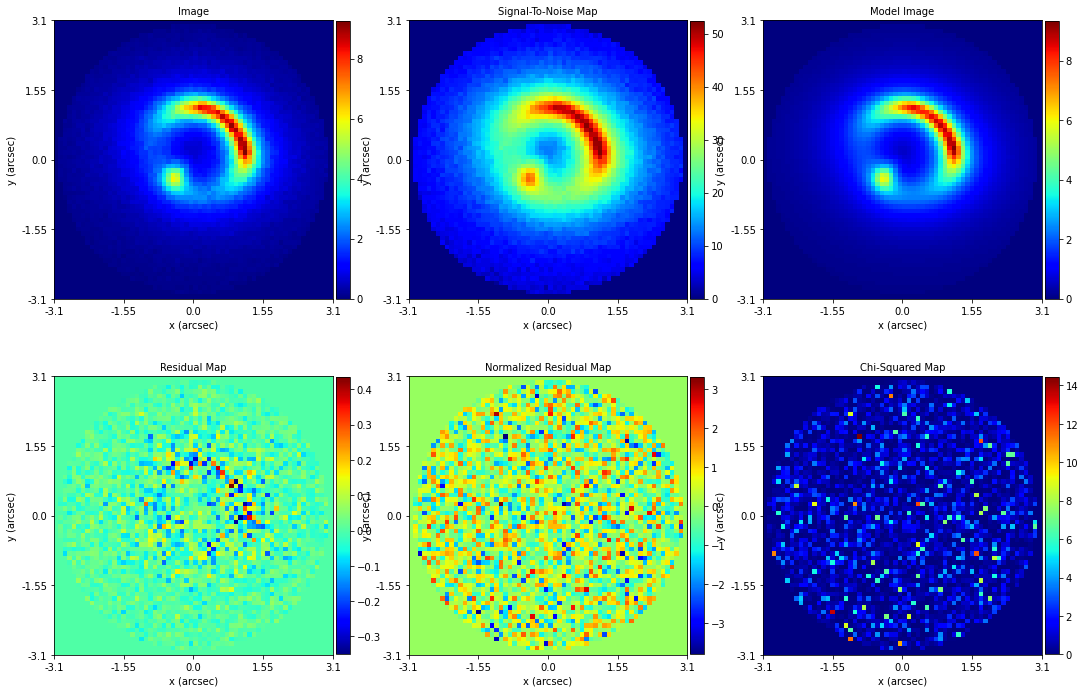

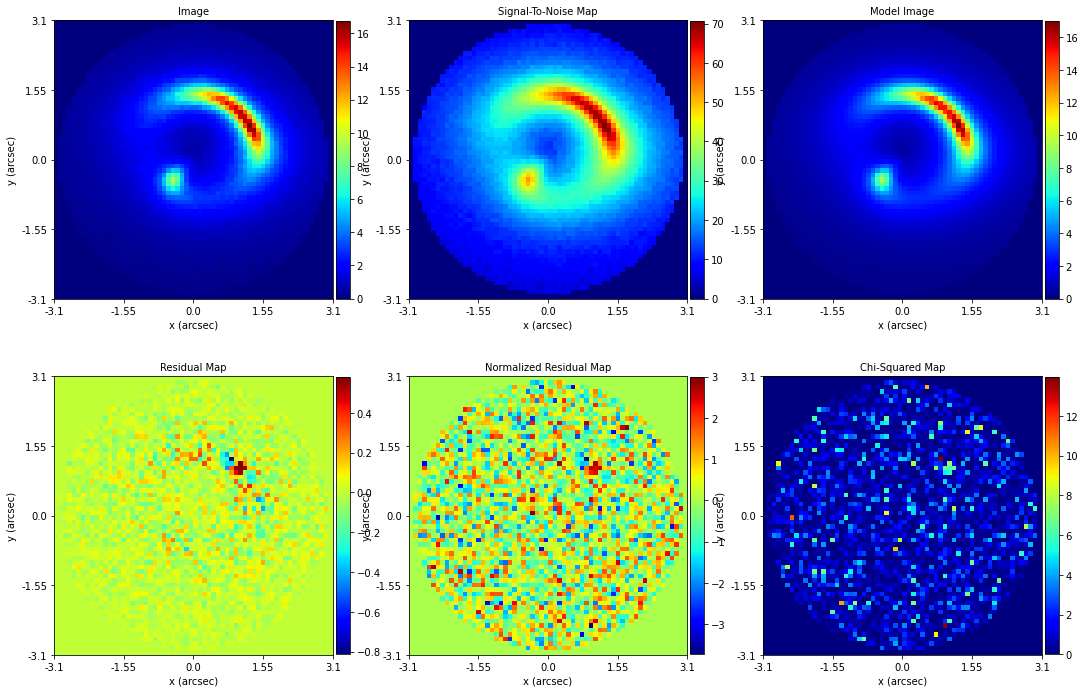

In [11]:


def plot_fit(agg_obj):

    masked_imaging = al.agg.masked_imaging_from_agg_obj(agg_obj=agg_obj)

    tracer = al.agg.tracer_from_agg_obj(agg_obj=agg_obj)

    return al.FitImaging(masked_imaging=masked_imaging, tracer=tracer)


fit_gen = agg_filter.map(func=make_fit_generator)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

Of course, we also provide a convenience method to directly make the MaskedImaging and FitImaging generators!

mass_sie__source_sersic__0
mass_sie__source_sersic__1
mass_sie__source_sersic__2


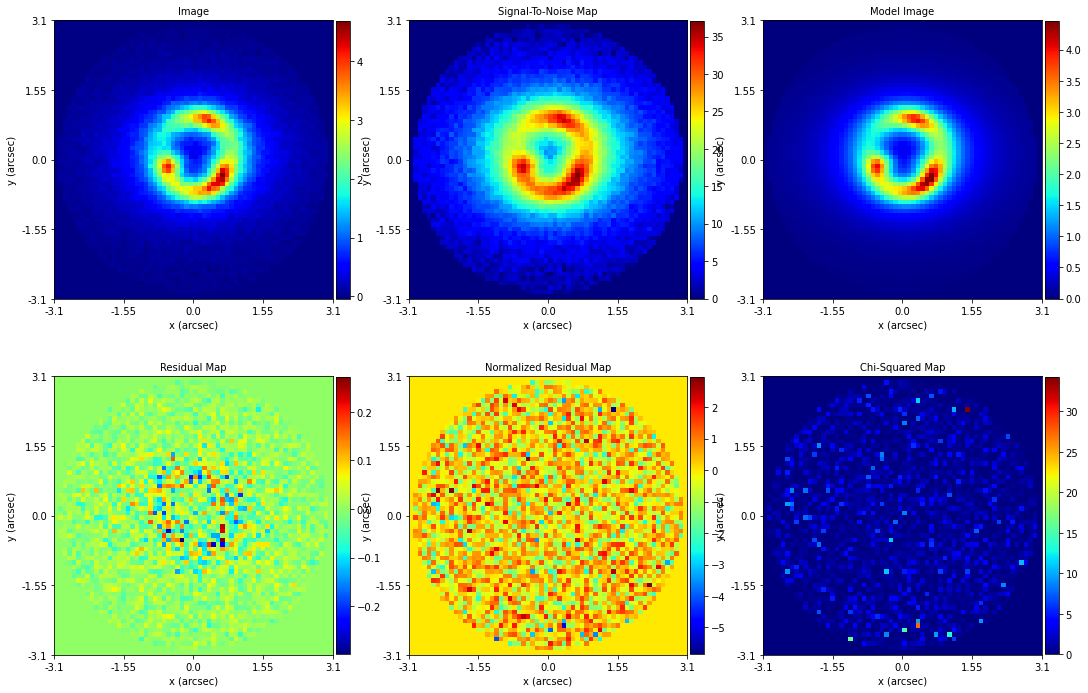

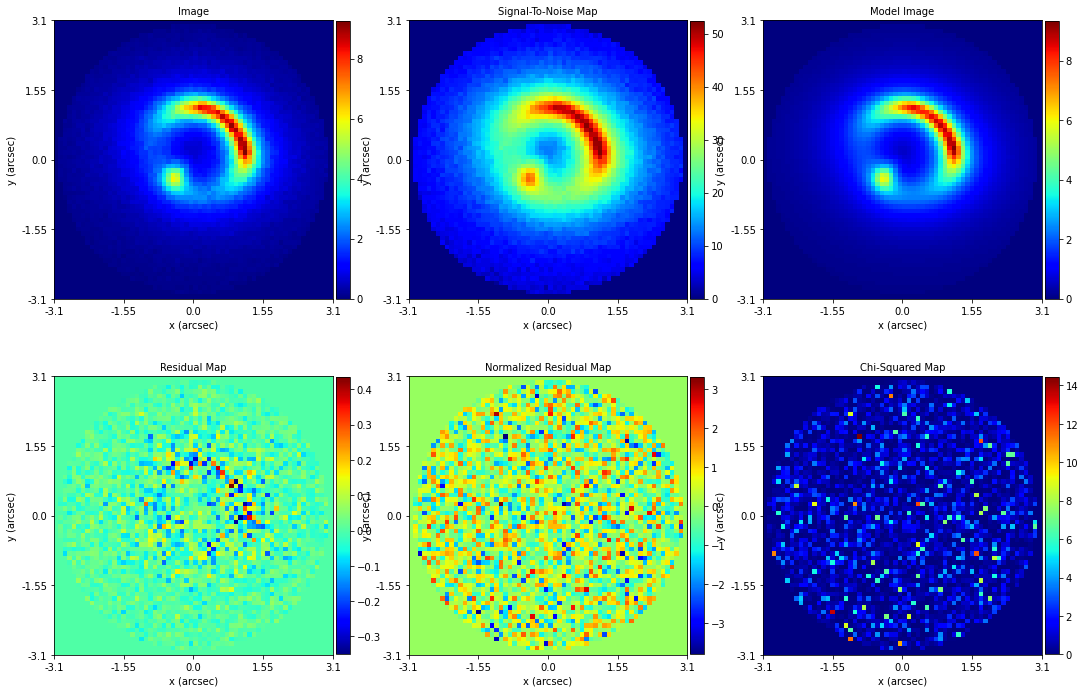

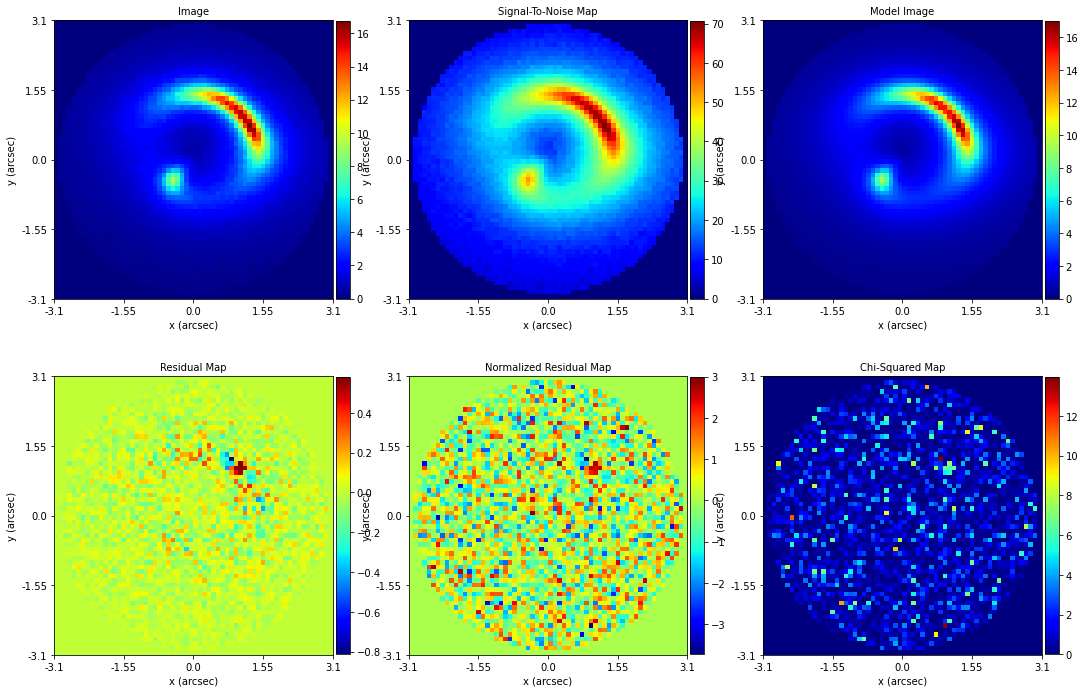

In [12]:
masked_imaging_gen = al.agg.MaskedImaging(aggregator=agg_filter)

for masked_imaging in masked_imaging_gen:
    print(masked_imaging.name)

fit_gen = al.agg.FitImaging(aggregator=agg_filter)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

This convenience method goes one step further. By default, it uses the `SettingsMaskedImaging`, _SettingsPixelization_
and `SettingsInversion` used by the analysis. 

However, we may want to change this. For example, what if I was curious and wanted to see the fit but where I used
a `Grid2D` with a *sub_size* of 4? Or where the `Pixelization` didn`t use a border? You can do this by passing the
method a new `Settings` object which overwrites the one used by the analysis.

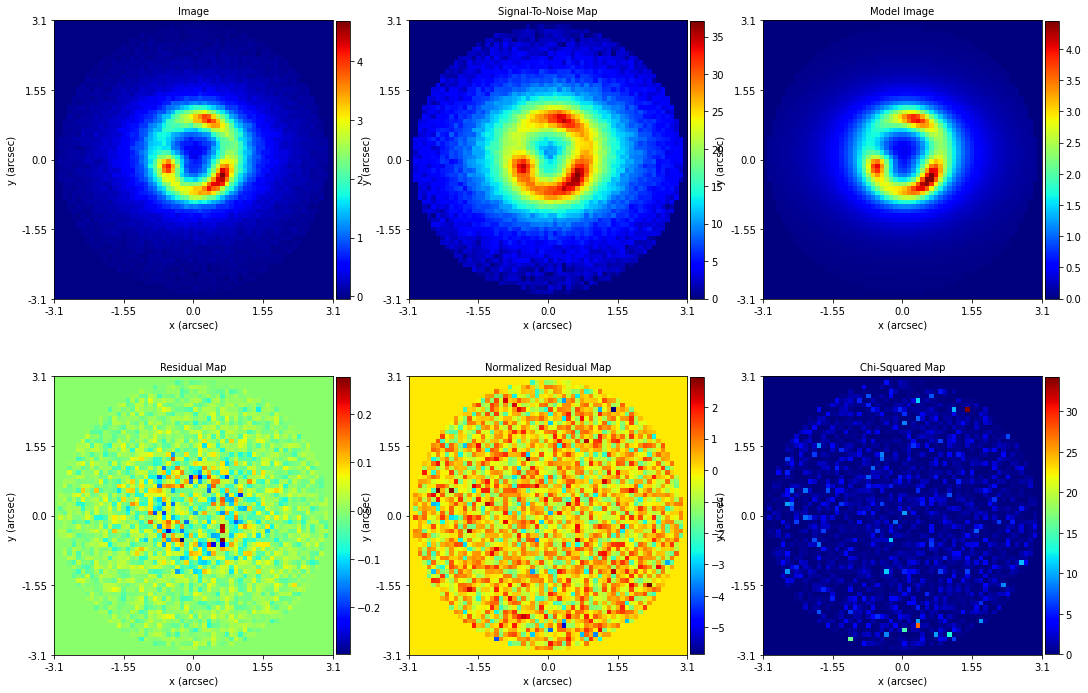

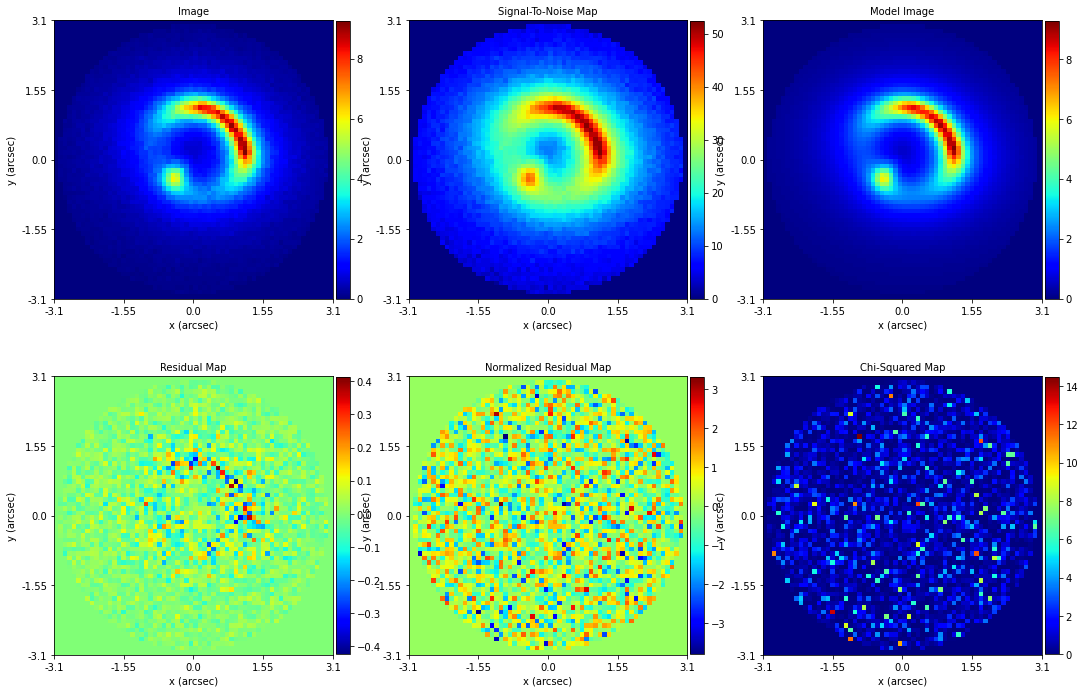

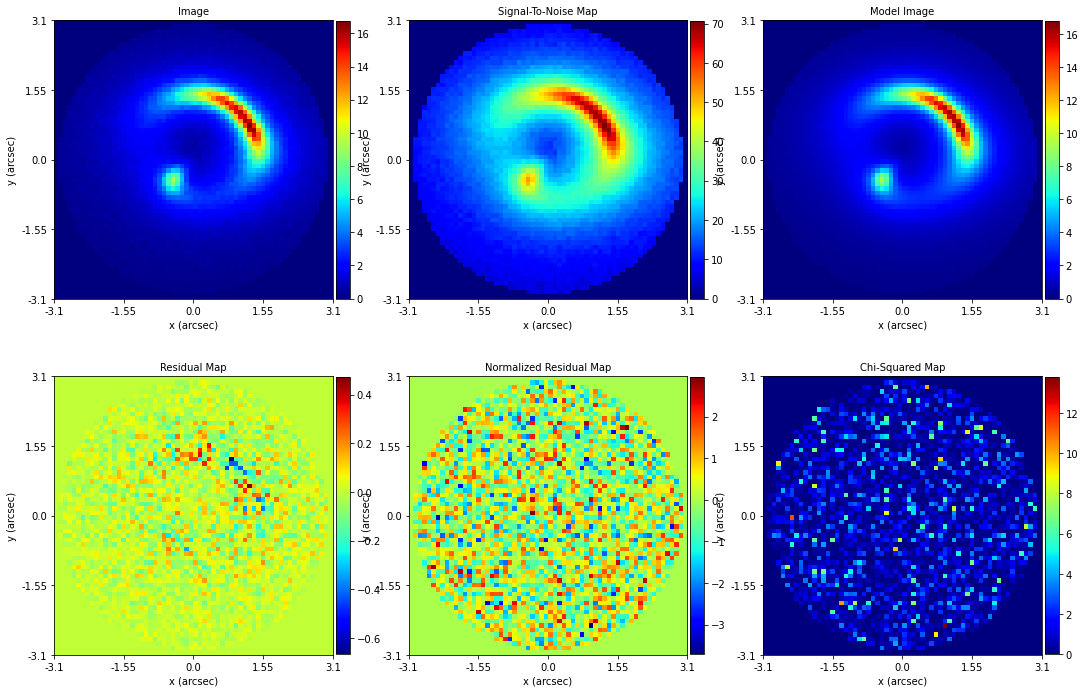

In [13]:
settings_masked_imaging = al.SettingsMaskedImaging(sub_size=4)

masked_imaging_gen = al.agg.MaskedImaging(
    aggregator=agg_filter, settings_masked_imaging=settings_masked_imaging
)

settings_pixelization = al.SettingsPixelization(use_border=False)

fit_gen = al.agg.FitImaging(
    aggregator=agg_filter,
    settings_masked_imaging=settings_masked_imaging,
    settings_pixelization=settings_pixelization,
)

for fit in fit_gen:
    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit)
    fit_imaging_plotter.subplot_fit_imaging()

The benefit of inspecting fits using the aggregator, rather than the files outputs to the hard-disk, is that we can 
customize the plots using the PyAutoLens mat_plot_2d.

Below, we create a new function to apply as a generator to do this. However, we use a convenience method available 
in the PyAutoLens aggregator package to set up the fit.

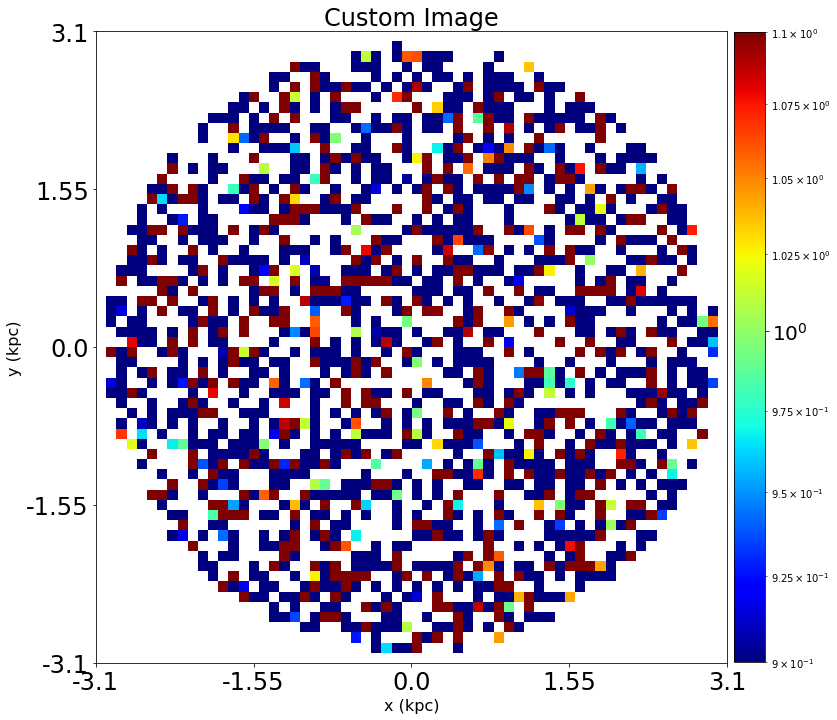

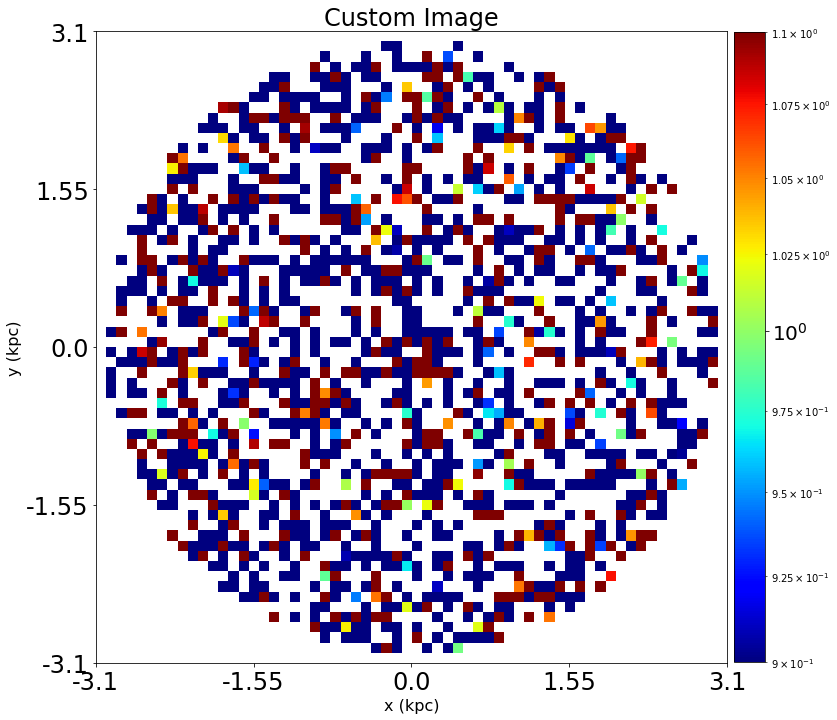

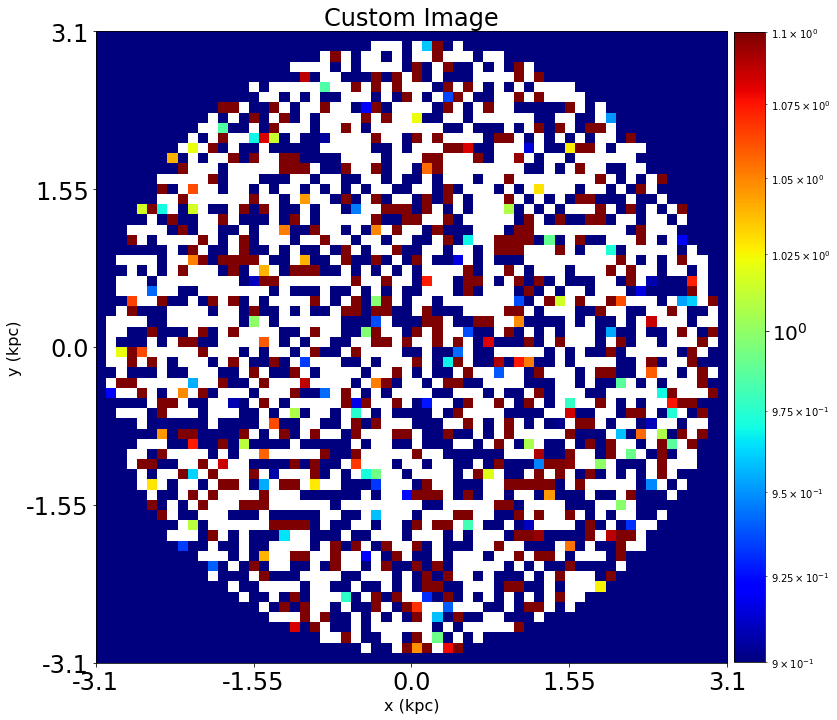

In [14]:
fit_gen = al.agg.FitImaging(aggregator=agg_filter)

for fit in fit_gen:

    mat_plot_2d = aplt.MatPlot2D(
        figure=aplt.Figure(figsize=(12, 12)),
        title=aplt.Title(label="Custom Image", fontsize=24),
        yticks=aplt.YTicks(fontsize=24),
        xticks=aplt.XTicks(fontsize=24),
        cmap=aplt.Cmap(norm="log", vmax=1.0, vmin=1.0),
        colorbar_tickparams=aplt.ColorbarTickParams(labelsize=20),
        units=aplt.Units(in_kpc=True),
    )

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, mat_plot_2d=mat_plot_2d)
    fit_imaging_plotter.figures(normalized_residual_map=True)

Making this plot for a paper? You can output it to hard disk.

In [15]:
fit_gen = al.agg.FitImaging(aggregator=agg_filter)

for fit in fit_gen:

    mat_plot_2d = aplt.MatPlot2D(
        title=aplt.Title(label="Hey"),
        output=aplt.Output(
            path=path.join("output", "path", "of", "file"),
            filename="publication",
            format="png",
        ),
    )

    fit_imaging_plotter = aplt.FitImagingPlotter(fit=fit, mat_plot_2d=mat_plot_2d)
    fit_imaging_plotter.figures(normalized_residual_map=True)

Finished.